In [29]:
import numpy as np 
import pandas as pd

import re
import string
import os

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
df_train = pd.read_csv("./labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
df_train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [38]:
df_test=pd.read_csv("./testData.tsv", header=0, delimiter="\t", quoting=3)
df_test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [39]:
def data_munging(raw_data):
    # 1. Remove HTML
#     review_text = BeautifulSoup(raw_review, 'lxml').get_text() 
    
    # 2. Remove non-letters with regex
    
    raw_data = raw_data.translate(str.maketrans('', '', string.punctuation + string.digits))
#     letters_only = re.sub("[^a-zA-Z]", " ", raw_data) 
    
    # 3. Convert to lower case, split into individual words
    words = raw_data.lower().split()                           
    
    # 4. Create set of stopwords
    stops = set(stopwords.words("english"))                  
    
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

df_train['review']=df_train['review'].apply(data_munging)
df_test["review"]=df_test["review"].apply(data_munging)

In [41]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

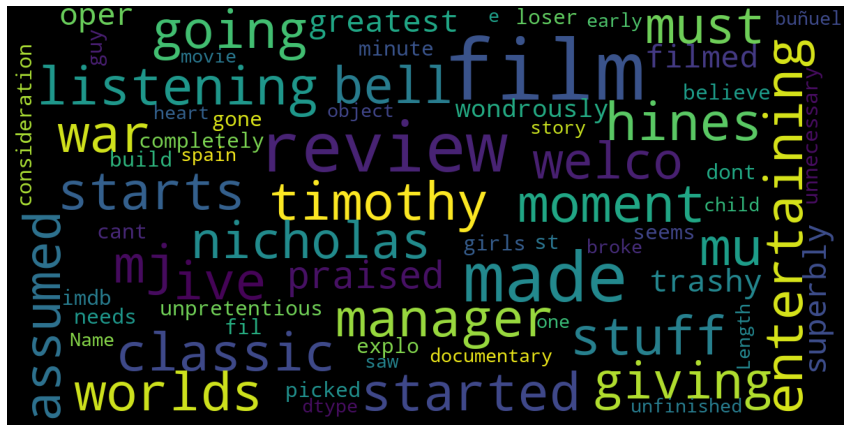

In [42]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df_train["review"])

In [43]:
df_train.isnull().sum(),df_test.isnull().sum()

(id           0
 sentiment    0
 review       0
 dtype: int64,
 id        0
 review    0
 dtype: int64)

In [1]:
import tensorflow as tf
# from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [45]:
list_classes = ["sentiment"]
y = df_train[list_classes].values
list_sentences_train = df_train["review"]
list_sentences_test = df_test["review"]

In [46]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

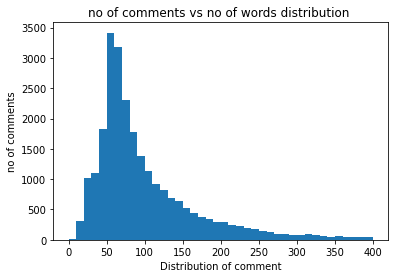

In [47]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.xlabel("Distribution of comment")
plt.ylabel("no of comments")
plt.title("no of comments vs no of words distribution ")
plt.show()

In [48]:
maxlen = 370
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [109]:
if not os.path.exists('my_folder'):
    os.makedirs('./saved_weights/my_folder')

In [110]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.95:
            print('\n Stopped Training!\n')
            self.model.stop_training = True

def train_model(model, model_name, n_epochs, batch_size, X_data, y_data, validation_split):
    if not os.path.exists(model_name):
        os.makedirs('./saved_weights/'+model_name)
    checkpoint_path = "./saved_weights/"+model_name
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    checkpoint_dir = os.path.dirname(checkpoint_path)
    callbacks = myCallback()
    history = model.fit(
        X_data,
        y_data,
        steps_per_epoch=batch_size,
        epochs=n_epochs,
        validation_split=validation_split,
        verbose=1,
        callbacks=[cp_callback]
    )
    return history

In [107]:
def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## MODEL A

In [98]:
class Model_A():
    def __new__(self):
        inp = Input(shape=(maxlen, ))
        embed_size = 128
        x = Embedding(max_features, embed_size)(inp)
        x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
        x = GlobalMaxPool1D()(x)
        x = Dropout(0.1)(x)
        x = Dense(50, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
        
    
model_a = Model_A()

In [99]:
print(model_a.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 370)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 370, 128)          768000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 370, 60)           45360     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 60)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)              

In [105]:
history_a = train_model(model_a, "model_a", 5, 32, X_t, y, 0.2)

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.8327
Epoch 00001: saving model to .\saved_weights
32/32 [==============================] - 118s 4s/step - loss: 0.4377 - accuracy: 0.8327 - val_loss: 0.3539 - val_accuracy: 0.8558
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.8985
Epoch 00002: saving model to .\saved_weights
32/32 [==============================] - 122s 4s/step - loss: 0.2701 - accuracy: 0.8985 - val_loss: 0.3284 - val_accuracy: 0.8628
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9267
Epoch 00003: saving model to .\saved_weights
32/32 [==============================] - 127s 4s/step - loss: 0.2052 - accuracy: 0.9267 - val_loss: 0.3358 - val_accuracy: 0.8602
Epoch 4/5
32/32 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9441
Epoch 00004: saving model to .\saved_weights
32/32 [==============================] - 132s 4s/step - lo

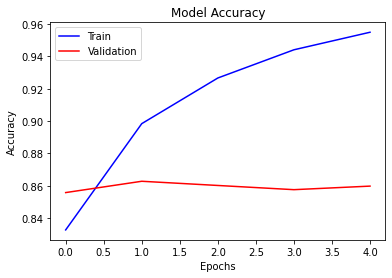

In [108]:
generate_graph(history_a)

## MODEL B

In [111]:
class Model_B():
    def __new__(self):
        x = Embedding(max_features, embed_size)(inp)
        x = SpatialDropout1D(0.25)(x)
        x = LSTM(50, dropout=0.5, recurrent_dropout=0.5)(x)
        x = Dropout(0.5)(x)
        x = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
        return model
    
model_b = Model_B()

In [112]:
print(model_b.summary())

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 370)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 370, 128)          768000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 370, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 803,851
Trainable params: 803,851
Non-trainable params: 0
_______________________________________________

In [2]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Please install GPU version of TF


In [113]:
history_b = train_model(model_b, "model_b", 5, 32, X_t, y, 0.2)

Epoch 1/5
 7/32 [=====>........................] - ETA: 2:56 - loss: 0.6924 - accuracy: 0.5129

KeyboardInterrupt: 

In [64]:
batch_size = 64
epochs = 3
model_b.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.3)

Epoch 1/3
274/274 [==============================] - 238s 870ms/step - loss: 0.4520 - accuracy: 0.7849 - val_loss: 0.3134 - val_accuracy: 0.8709
Epoch 2/3
274/274 [==============================] - 240s 874ms/step - loss: 0.2741 - accuracy: 0.8945 - val_loss: 0.3449 - val_accuracy: 0.8760
Epoch 3/3
274/274 [==============================] - 239s 872ms/step - loss: 0.2241 - accuracy: 0.9144 - val_loss: 0.3510 - val_accuracy: 0.8701


In [65]:
prediction = model_b.predict(X_te)
y_pred = (prediction > 0.5)

In [23]:
df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = df_test["sentiment"]

In [24]:
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.85229134204323
Confusion matrix:


array([[10637,  1834],
       [ 1863, 10666]], dtype=int64)

In [33]:
df_test['review'][0]

'naturally film main themes mortality nostalgia loss innocence perhaps surprising rated highly older viewers younger ones however craftsmanship completeness film anyone enjoy pace steady constant characters full engaging relationships interactions natural showing need floods tears show emotion screams show fear shouting show dispute violence show anger naturally joyce short story lends film ready made structure perfect polished diamond small changes huston makes inclusion poem fit neatly truly masterpiece tact subtlety overwhelming beauty'